In [1]:
import uuid
import os,json
import warnings
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
print("TensorFlow version: ", tf.__version__)
os.environ['TF_USE_LEGACY_KERAS'] = "True"
warnings.filterwarnings("ignore")

TensorFlow version:  2.10.1


In [2]:
image_dir = 'data/TreeSegmentation/processed/images/'
mask_dir = 'data/TreeSegmentation/processed/masks/'

input_shape = (256, 256, 3)
output_shape_orig = (256, 256, 3)
output_shape_new = (65536, 2)
# output_shape_new = (65536, )

segmentation_weights = 'artifacts/model_tree.h5'

background_color = (0, 0, 0)
building_color = (255, 255, 255)

# Build Dataset

In [3]:
def load_annotations(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    image_data = data['images']
    df_images = pd.DataFrame(image_data)
    df_images = df_images[['id', 'file_name']]
    image_dir = os.path.dirname(json_path)
    df_images['file_name'] = df_images['file_name'].apply(lambda x: os.path.join(image_dir, x).replace('\\', '/'))

    annotation_data = data['annotations']
    df_annotations = pd.DataFrame(annotation_data)
    df_annotations = df_annotations[['image_id', 'category_id', 'segmentation']]
    df = pd.merge(df_annotations, df_images, left_on='image_id', right_on='id')
    df = df.drop(columns=['id'])
    df = df[df['category_id'] == 4]
    return df

In [4]:
json_path = 'data/TreeSegmentation/raw/valid/_annotations.coco.json'
load_annotations(json_path)

image_id  category_id                                       segmentation  \
2           0            4  [[1857.117, 1096.974, 1852.565, 1092.422, 1843...   
8           0            4  [[4515.344, 723.729, 4524.447, 714.626, 4524.4...   
9           0            4  [[4533.551, 368.692, 4538.103, 364.141, 4556.3...   
10          0            4  [[4515.344, 1315.458, 4519.896, 1310.906, 4528...   
12          0            4  [[3677.82, 2808.435, 3682.372, 2803.883, 3691....   
..        ...          ...                                                ...   
842        14            4  [[1784.289, 1415.597, 1784.289, 1406.493, 1793...   
843        14            4  [[1729.668, 1652.288, 1734.22, 1647.736, 1743....   
844        14            4  [[464.279, 295.864, 487.038, 273.105, 496.142,...   
845        14            4  [[1693.254, 186.622, 1729.668, 150.208, 1729.6...   
846        14            4  [[1502.08, 77.38, 1511.184, 68.276, 1511.184, ...   

                                             file_name  
2    data/TreeSegmentation/raw/valid/144_jpg.rf.546...  
8    data/TreeSegmentation/raw/valid/144_jpg.rf.546...  
9    data/TreeSegmentation/raw/valid/144_jpg.rf.546...  
10   data/TreeSegmentation/raw/valid/144_jpg.rf.546...  
12   data/TreeSegmentation/raw/valid/144_jpg.rf.546...  
..                                                 ...  
842  data/TreeSegmentation/raw/valid/128_jpg.rf.47d...  
843  data/TreeSegmentation/raw/valid/128_jpg.rf.47d...  
844  data/TreeSegmentation/raw/valid/128_jpg.rf.47d...  
845  data/TreeSegmentation/raw/valid/128_jpg.rf.47d...  
846  data/TreeSegmentation/raw/valid/128_jpg.rf.47d...  

[534 rows x 4 columns]

In [5]:
def draw_annotations(df):
    image_ids = df['image_id'].unique()
    for image_id in image_ids:
        df_image = df[df['image_id'] == image_id]
        image_path = df_image['file_name'].values[0]
        image = cv.imread(image_path)
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        for _, row in df_image.iterrows():
            segmentation = row['segmentation']
            segmentation = np.array(segmentation).reshape(-1, 2).astype(np.int32)
            cv.fillPoly(mask, [segmentation], 255)

        uuid_str = str(uuid.uuid4())
        image_path = f'data/TreeSegmentation/processed/images/{uuid_str}.png'
        mask_path = f'data/TreeSegmentation/processed/masks/{uuid_str}.png'

        cv.imwrite(image_path, image)
        cv.imwrite(mask_path, mask)


In [6]:
# df = load_annotations(json_path = 'data/TreeSegmentation/raw/valid/_annotations.coco.json')
# draw_annotations(df)

# df = load_annotations(json_path = 'data/TreeSegmentation/raw/train/_annotations.coco.json')
# draw_annotations(df)

# df = load_annotations(json_path = 'data/TreeSegmentation/raw/test/_annotations.coco.json')
# draw_annotations(df)

# Data Preprocessing

In [7]:
def minmax_norm(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

def standar_norm(img):
    return (img - np.mean(img)) / np.std(img)

def preprocess_input(image_path):
    img = cv.imread(image_path)
    original_img = img
    
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = np.asarray(img).astype("f")
    img = cv.resize(img, (input_shape[0], input_shape[1]), interpolation = cv.INTER_AREA)
    img = minmax_norm(img)
    return img, original_img

def preprocess_output(mask_path):
    mask = cv.imread(mask_path)
    mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
    mask = cv.resize(mask, (output_shape_orig[0], output_shape_orig[1]), interpolation = cv.INTER_AREA)

    mask_new = np.zeros((mask.shape[0], mask.shape[1]))
    mask_new[np.all(mask == background_color, axis=-1)] = 0
    mask_new[np.all(mask == building_color, axis=-1)] = 1
        
    mask_new = mask_new.reshape(mask_new.shape[0] * mask_new.shape[1],)
    mask_new = tf.one_hot(mask_new, 2).numpy()
    return mask_new  

In [8]:
def prepare_dataset(image_dir = 'data/TreeSegmentation/processed/images/'):
    image_files = os.listdir(image_dir)
    X = np.zeros((len(image_files), input_shape[0], input_shape[1], input_shape[2]))
    Z = []
    if len(output_shape_new) > 1:
        Y = np.zeros((len(image_files), output_shape_new[0], output_shape_new[1]))
    else:
        Y = np.zeros((len(image_files), output_shape_new[0]))
    
    for i in range(len(image_files)):
        image_path = image_dir + image_files[i]
        mask_path = mask_dir + image_files[i]
        X[i] = preprocess_input(image_path)[0]
        Y[i] = preprocess_output(mask_path)
        Z.append(image_files[i].split('./')[-1])

    return X, Y, Z

In [9]:
X, Y, Z = prepare_dataset()
print('input shape : ', X.shape)
print('output shape : ', Y.shape)

input shape :  (258, 256, 256, 3)
output shape :  (258, 65536, 2)


00f16fff-c8d2-47f0-943e-e4d562d06248.png
01df9ca2-41d3-4aa9-bd23-00d409c31dc3.png
0386f6b7-9565-4edc-9474-95bc8d940b67.png
03dc35a9-6e99-4b19-8c73-1f7eb67483e8.png


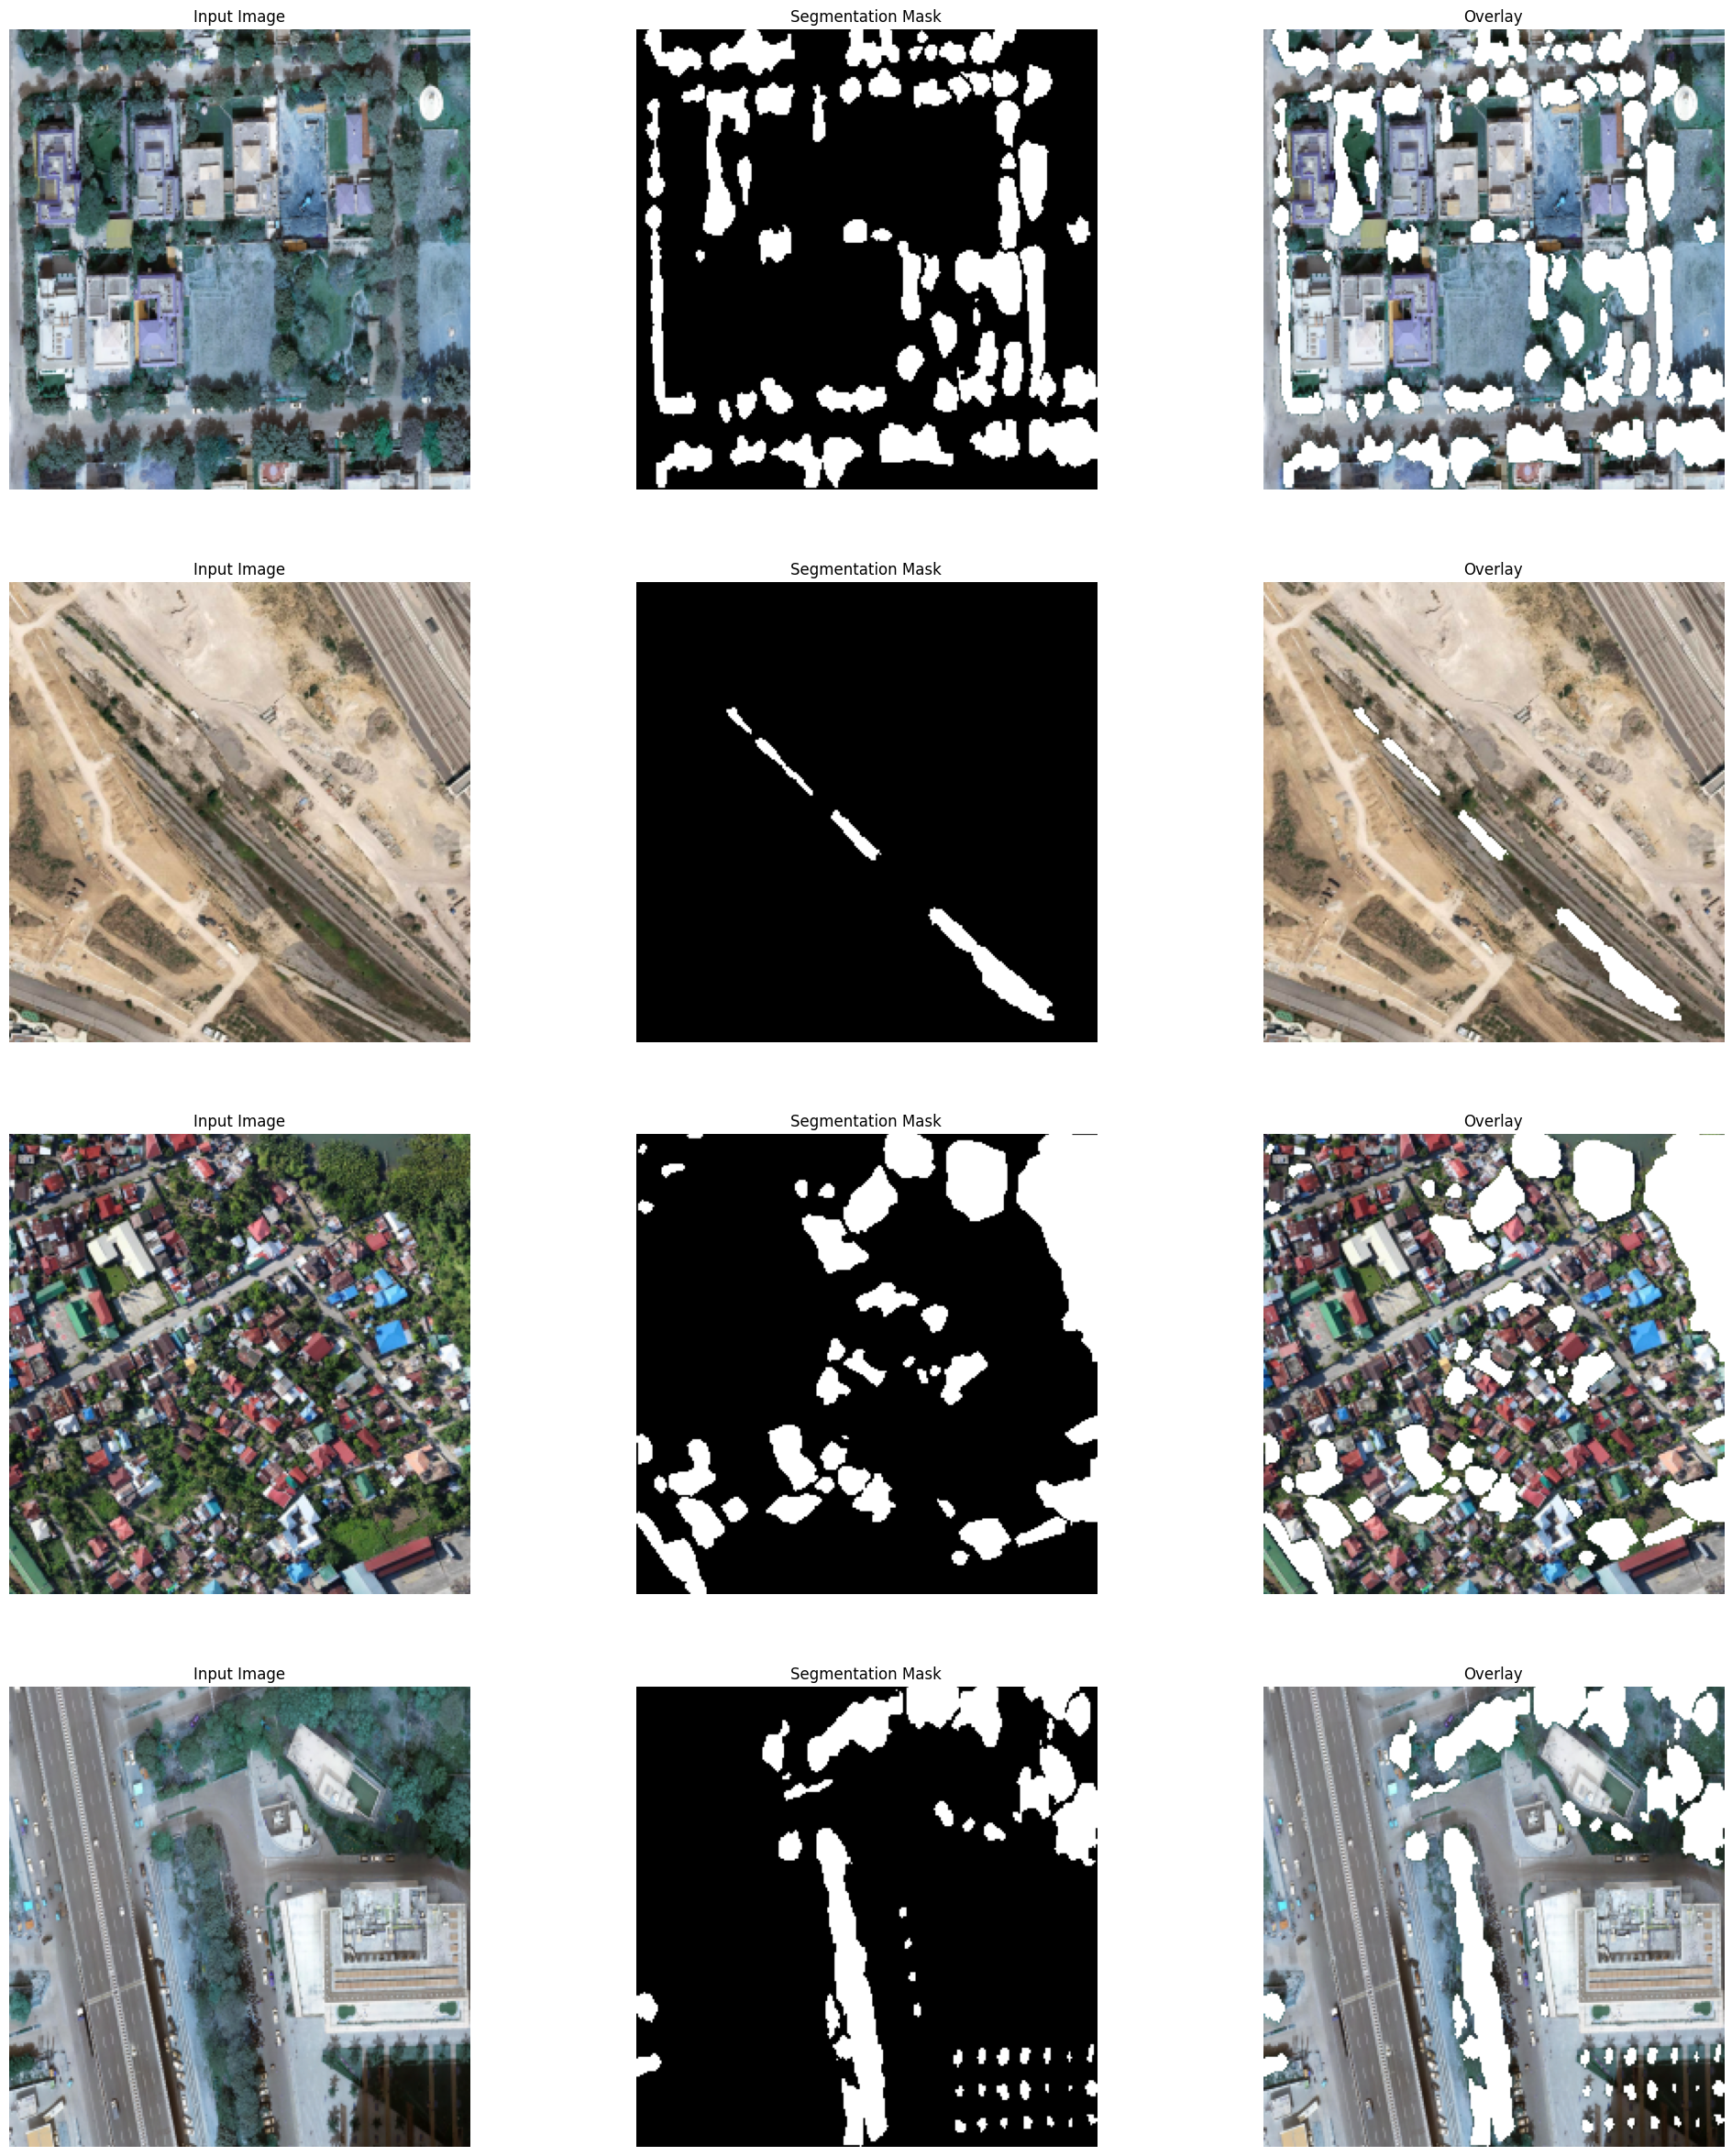

In [10]:
def visualize_processed_data(X, Y, n = 4):
    fig, ax = plt.subplots(n, 3, figsize=(25, 30))
    for i in range(n):
        x = X[i]
        x_cp = x.copy()

        y = Y[i]
        if len(y.shape) > 1:
            y = np.argmax(y, axis=-1)

        y_img = np.zeros((output_shape_new[0], 3))
        y_img[np.where(y == 0)] = background_color
        y_img[np.where(y == 1)] = building_color
        y_img = y_img.reshape(output_shape_orig[0], output_shape_orig[1], 3)

        one_dim_idxs = np.where(y == 1)[0]
        two_dim_idxs = np.unravel_index(one_dim_idxs, (output_shape_orig[0], output_shape_orig[1]))
        x_cp[two_dim_idxs] = 1.0

        print(Z[i])
        ax[i, 0].imshow((x * 255.0).astype('uint8'))
        ax[i, 0].axis('off')

        ax[i, 1].imshow(y_img.astype('uint8'))
        ax[i, 1].axis('off')

        ax[i, 2].imshow(x_cp)
        ax[i, 2].axis('off')

        ax[i, 0].set_title('Input Image')
        ax[i, 1].set_title('Segmentation Mask')
        ax[i, 2].set_title('Overlay')

    plt.show()

visualize_processed_data(X, Y)

# Model Dev

In [11]:
raw_output = Y.argmax(axis=-1).reshape(-1,)

class_weights = compute_class_weight(
                                    'balanced',
                                    classes = np.unique(raw_output),
                                    y = raw_output
                                    )

'''

Eqn : Total Number of Samples / (2 * Number of Samples in Given Class)

'''
class_weights = {i : class_weights[i] for i in range(len(set(raw_output)))}
class_weights

{0: 0.6636410571573301, 1: 2.0277339583527714}

In [12]:
if len(output_shape_new) > 1:
    binary_output = Y.argmax(axis=-1)
else:
    binary_output = Y
   
sample_weight = np.zeros((Y.shape[0], Y.shape[1]))
sample_weight[np.where(binary_output == 0)] = class_weights[0]
sample_weight[np.where(binary_output == 1)] = class_weights[1]

In [ ]:
def downsample_block(filters, input):
    conv = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', 
              kernel_initializer='he_normal', padding='same')(input)
    conv = tf.keras.layers.Dropout(0.2)(conv)
    conv = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', 
              kernel_initializer='he_normal', padding='same')(conv)
    pool = tf.keras.layers.MaxPool2D((2, 2))(conv)
    return pool, conv

def upsample_block(filters, conv, conv_p):
    up = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D((2, 2))(conv), conv_p], axis=-1)
    conv_n = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', 
              kernel_initializer='he_normal', padding='same')(up)
    conv_n = tf.keras.layers.Dropout(0.2)(conv_n)
    conv_n = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', 
              kernel_initializer='he_normal', padding='same')(conv_n)
    return conv_n

def Unet_model():
    input = tf.keras.layers.Input(shape=input_shape, name='input')
    pool1, conv1 = downsample_block(32, input)
    pool2, conv2 = downsample_block(64, pool1)
    pool3, conv3 = downsample_block(128, pool2)

    conv4 = downsample_block(128, pool3)[1]

    conv5 = upsample_block(64, conv4, conv3)
    conv6 = upsample_block(64, conv5, conv2)
    conv7 = upsample_block(32, conv6, conv1)
    conv8 = tf.keras.layers.Conv2D(2, (1, 1))(conv7)

    logits = tf.keras.layers.Reshape(
                output_shape_new, 
                input_shape = output_shape_orig
                )(conv8)
    output = tf.keras.layers.Softmax()(logits)

    model = tf.keras.models.Model(
                                inputs=input, 
                                outputs=output,
                                name='tree_segmentation'
                                )
    model.summary()
  
    return model

def train(model):
    early_stopping = tf.keras.callbacks.EarlyStopping(
                                                    patience=30,
                                                    monitor='loss',
                                                    restore_best_weights=True
                                                    )   

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                                                                0.001,
                                                                decay_steps=100000,
                                                                decay_rate=0.96,
                                                                staircase=True
                                                                )

    model.compile(
                loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(lr_schedule),
                metrics=[
                    tf.keras.metrics.CategoricalAccuracy(),
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    tf.keras.metrics.AUC()
                    ]
                )
    histroy = model.fit(
                        X, Y,
                        epochs=200,
                        batch_size=16,
                        callbacks=[early_stopping]
                        )
    
    model.save(segmentation_weights)
    return model, histroy

In [14]:
model = Unet_model()
model, histroy = train(model)

Model: "disease_classification"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 32  0           ['conv2d[0][0]']                 
                                )                                            

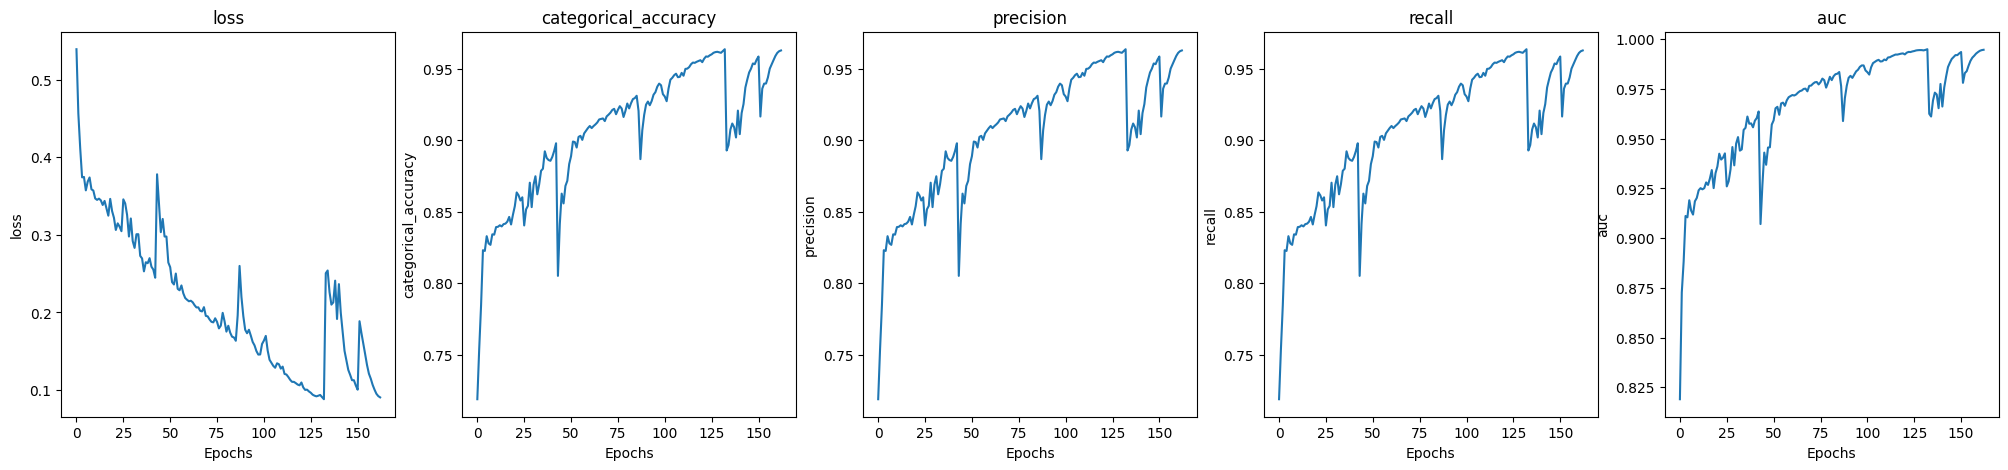

In [15]:
# PLOT LOSS AND METRICS in single plot
def plot_metrics(history, metrics = ['loss', 'categorical_accuracy', 'precision', 'recall', 'auc']):
    fig, ax = plt.subplots(1, len(metrics), figsize=(25, 5))
    for i in range(len(metrics)):
        ax[i].plot(history.history[metrics[i]])
        ax[i].set_title(metrics[i])
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
    plt.show()

plot_metrics(histroy)

# Inference

In [38]:
model = tf.keras.models.load_model(segmentation_weights)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                                                            0.001,
                                                            decay_steps=100000,
                                                            decay_rate=0.96,
                                                            staircase=True
                                                            )
model.compile(
            loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.legacy.Adam(lr_schedule),
            metrics=[
                tf.keras.metrics.CategoricalAccuracy(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.AUC()
                ]
            )

In [39]:
def calculate_iou(mask_img, pred_img):
    intersection = np.logical_and(mask_img, pred_img)
    union = np.logical_or(mask_img, pred_img)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def visualize_inference(
                        image_path,
                        mask_dir = 'data/TreeSegmentation/processed/masks/'
                        ):
    mask_path = mask_dir + image_path.split('/')[-1]

    img, original_img = preprocess_input(image_path)
    mask_img = cv.imread(mask_path)
    mask_img = cv.cvtColor(mask_img, cv.COLOR_BGR2RGB)
    mask_img = cv.resize(mask_img, (output_shape_orig[0], output_shape_orig[1]), interpolation = cv.INTER_AREA)

    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = np.argmax(pred, axis=-1).squeeze()

    pred_img = np.zeros((output_shape_new[0], 3))
    pred_img[np.where(pred == 0)] = background_color
    pred_img[np.where(pred == 1)] = building_color
    pred_img = pred_img.reshape(output_shape_orig[0], output_shape_orig[1], 3)

    # overlay = original_img.copy()
    # overlay = cv.resize(overlay, (output_shape_orig[0], output_shape_orig[1]), interpolation = cv.INTER_AREA)
    # overlay = overlay.reshape(-1, 3)
    # overlay[np.where(pred == 1)] = (128, 0, 0)
    # overlay = overlay.reshape(output_shape_orig[0], output_shape_orig[1], 3)

    # draw outer polygon of the segmented buildings
    contour_img = original_img.copy()
    contour_img = cv.resize(contour_img, (output_shape_orig[0], output_shape_orig[1]), interpolation = cv.INTER_AREA)
    contour_img = cv.cvtColor(contour_img, cv.COLOR_BGR2RGB)

    pred_img_gray = np.uint8(pred_img[:, :, 0])
    edged = cv.Canny(pred_img_gray, 30, 200)
    contours, hierarchy = cv.findContours(
                                            edged,  
                                            cv.RETR_EXTERNAL, 
                                            cv.CHAIN_APPROX_NONE
                                            ) 
    cv.drawContours(contour_img, contours, -1, (255, 0, 0), 1)
    
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(mask_img)
    plt.title('Original Mask')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(pred_img)
    plt.title('Predict Mask')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(contour_img)
    plt.title('Contour Image')
    plt.axis('off')

    plt.show()

    print('IoU Score : ', calculate_iou(mask_img, pred_img))

data/TreeSegmentation/processed/images/0479b080-4af8-4073-9b5c-07e7413a793e.png
1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


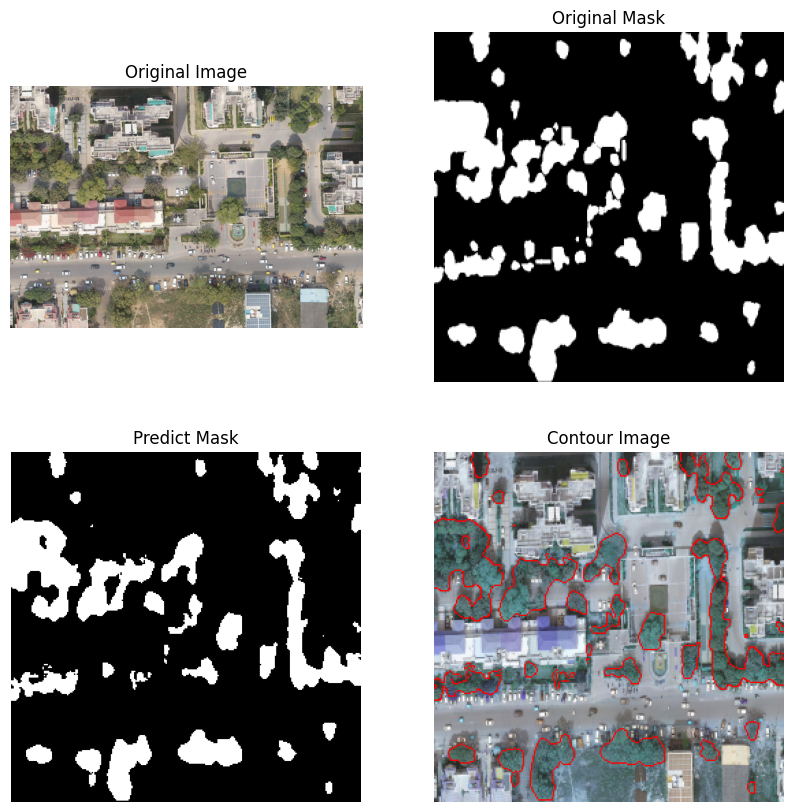

IoU Score :  0.7067994546209022


In [42]:
data_dir = 'data/TreeSegmentation/processed/images/'
all_images = os.listdir(data_dir)
all_images = [data_dir + img for img in all_images]
rand_image = np.random.choice(all_images)
print(rand_image)
visualize_inference(rand_image)

# Evaluation on Test Set

In [19]:
import os
import warnings
import cv2 as cv
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

print("TensorFlow version: ", tf.__version__)
warnings.filterwarnings("ignore")

TensorFlow version:  2.10.1


In [20]:
image_dir = 'data/images/'
mask_dir = 'data/masks/'

input_shape = (256, 256, 3)
output_shape_orig = (256, 256, 3)
output_shape_new = (65536, 2)
# output_shape_new = (65536, )

segmentation_weights = 'artifacts/model_tree.h5'

background_color = (0, 0, 0)
building_color = (255, 255, 255)

In [21]:
model = tf.keras.models.load_model(segmentation_weights)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                                                            0.001,
                                                            decay_steps=100000,
                                                            decay_rate=0.96,
                                                            staircase=True
                                                            )
model.compile(
            loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.legacy.Adam(lr_schedule),
            metrics=[
                tf.keras.metrics.CategoricalAccuracy(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.AUC()
                ]
            )

In [22]:
def calculate_iou(mask_img, pred_img):
    intersection = np.logical_and(mask_img, pred_img)
    union = np.logical_or(mask_img, pred_img)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def prepare_dataset(
                    image_dir = 'data/images/',
                    mask_dir = 'data/masks/'
                    ):
    image_files = os.listdir(image_dir)
    X = np.zeros((len(image_files), input_shape[0], input_shape[1], input_shape[2]))
    Z = []
    if len(output_shape_new) > 1:
        Y = np.zeros((len(image_files), output_shape_new[0], output_shape_new[1]))
    else:
        Y = np.zeros((len(image_files), output_shape_new[0]))
    
    for i in range(len(image_files)):
        image_path = image_dir + image_files[i]
        mask_path = mask_dir + image_files[i]
        X[i] = preprocess_input(image_path)[0]
        Y[i] = preprocess_output(mask_path)
        Z.append(image_files[i].split('./')[-1])

    return X, Y, Z

def minmax_norm(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

def standar_norm(img):
    return (img - np.mean(img)) / np.std(img)

def preprocess_input(image_path):
    img = cv.imread(image_path)
    original_img = img
    
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = np.asarray(img).astype("f")
    img = cv.resize(img, (input_shape[0], input_shape[1]), interpolation = cv.INTER_AREA)
    img = minmax_norm(img)
    return img, original_img

def preprocess_output(mask_path):
    mask = cv.imread(mask_path)
    mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
    mask = cv.resize(mask, (output_shape_orig[0], output_shape_orig[1]), interpolation = cv.INTER_AREA)

    mask_new = np.zeros((mask.shape[0], mask.shape[1]))
    mask_new[np.all(mask == background_color, axis=-1)] = 0
    mask_new[np.all(mask == building_color, axis=-1)] = 1
        
    mask_new = mask_new.reshape(mask_new.shape[0] * mask_new.shape[1],)
    mask_new = tf.one_hot(mask_new, 2).numpy()
    return mask_new  

In [23]:
X, Y, Z = prepare_dataset(
                        image_dir = 'data/TreeSegmentation/processed/images/',
                        mask_dir = 'data/TreeSegmentation/processed/masks/'
                        )
print('input shape : ', X.shape)
print('output shape : ', Y.shape)

input shape :  (258, 256, 256, 3)
output shape :  (258, 65536, 2)


In [24]:
P = model.predict(X)

ious = []
bce_losses = []
for i in range(X.shape[0]):
    y = Y[i]
    p = P[i]
    if len(y.shape) > 1:
        y = np.argmax(y, axis=-1)
        p = np.argmax(p, axis=-1)

    iou = calculate_iou(y, p)
    bce_loss = float(tf.keras.losses.binary_crossentropy(y.astype(float), p.astype(float)).numpy())

    ious.append(iou)
    bce_losses.append(bce_loss)

9/9 [==============================] - 4s 100ms/step


In [25]:
print('Mean IoU : ', np.mean(ious))
print('Mean BCE Loss : ', np.mean(bce_losses))

Mean IoU :  0.8042291050545347
Mean BCE Loss :  0.49805551232668194


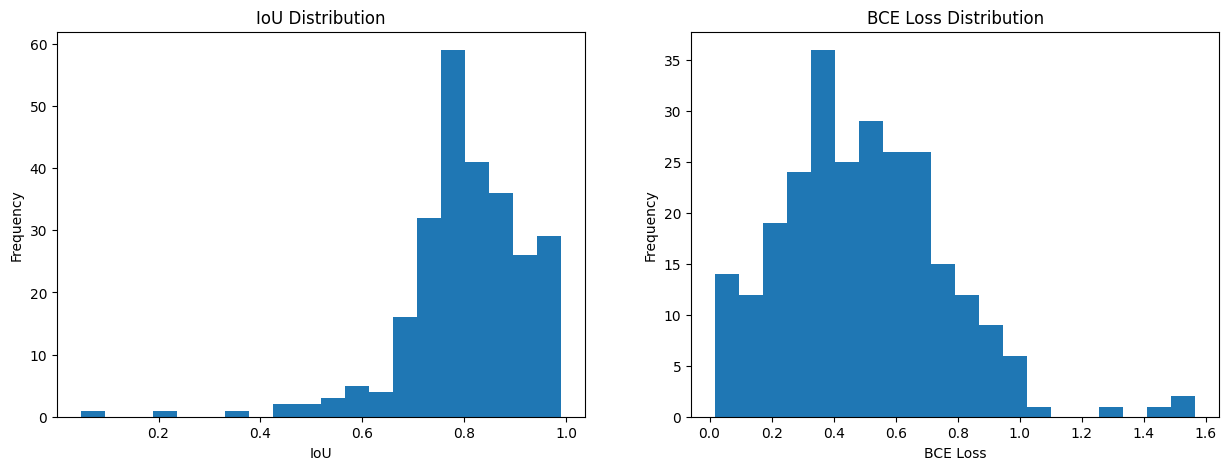

In [26]:
# plot the IoU and BCE Loss Distribution
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(ious, bins=20)
ax[0].set_title('IoU Distribution')
ax[0].set_xlabel('IoU')
ax[0].set_ylabel('Frequency')

ax[1].hist(bce_losses, bins=20)
ax[1].set_title('BCE Loss Distribution')
ax[1].set_xlabel('BCE Loss')
ax[1].set_ylabel('Frequency')

plt.show()

In [ ]:
def calc_vegitation_density(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    red_channel = image[:, :, 0].astype(float)
    green_channel = image[:, :, 1].astype(float)

    ndvi = (green_channel - red_channel) / (green_channel + red_channel + 1e-10)  # Adding a small constant to avoid division by zero
    high_density_mask = (ndvi > 0.6).astype(np.uint8) * 255
    medium_density_mask = ((ndvi > 0.3) & (ndvi <= 0.6)).astype(np.uint8) * 255
    low_density_mask = (ndvi <= 0.3).astype(np.uint8) * 255

    total_pixels = image.shape[0] * image.shape[1]
    high_density_percentage = (cv.countNonZero(high_density_mask) / total_pixels) * 100
    medium_density_percentage = (cv.countNonZero(medium_density_mask) / total_pixels) * 100
    low_density_percentage = (cv.countNonZero(low_density_mask) / total_pixels) * 100

    print(f"NDVI Score: {np.mean(ndvi):.2f}")
    print(f"High Vegetation Density Coverage: {high_density_percentage:.2f}%")
    print(f"Medium Vegetation Density Coverage: {medium_density_percentage:.2f}%")
    print(f"Low Vegetation Density Coverage: {low_density_percentage:.2f}%")


    # find inndexes that in high_density_percentage but not black
    non_zer_idxs = (image != [0, 0, 0]).all(axis=-1)
    image[(high_density_percentage > 0) and non_zer_idxs] = [0, 255, 0]
    image[(medium_density_percentage > 0) and non_zer_idxs] = [0, 128, 0]
    image[(low_density_percentage > 0) and non_zer_idxs] = [0, 64, 0]

    return image

def visualize_inference_modified(image_path):
        img, original_img = preprocess_input(image_path)

        img = np.expand_dims(img, axis=0)
        pred = model.predict(img)
        pred = np.argmax(pred, axis=-1).squeeze()

        pred_img = np.zeros((output_shape_new[0], 3))
        pred_img[np.where(pred == 0)] = background_color
        pred_img[np.where(pred == 1)] = building_color
        pred_img = pred_img.reshape(output_shape_orig[0], output_shape_orig[1], 3)

        # generate new image as background is black but foreground is in original color
        overlay = original_img.copy()
        overlay = cv.cvtColor(overlay, cv.COLOR_BGR2RGB)
        overlay = cv.resize(overlay, (output_shape_orig[0], output_shape_orig[1]), interpolation = cv.INTER_AREA)
        overlay = overlay.reshape(-1, 3)
        overlay[np.where(pred == 0)] = (0, 0, 0)
        overlay = overlay.reshape(output_shape_orig[0], output_shape_orig[1], 3)
        cv.imwrite('overlay.png', overlay)
        overlay = calc_vegitation_density(overlay)

        contour_img = original_img.copy()
        contour_img = cv.resize(contour_img, (output_shape_orig[0], output_shape_orig[1]), interpolation = cv.INTER_AREA)
        contour_img = cv.cvtColor(contour_img, cv.COLOR_BGR2RGB)

        pred_img_gray = np.uint8(pred_img[:, :, 0])
        edged = cv.Canny(pred_img_gray, 30, 200)
        contours, _ = cv.findContours(
                                                edged,  
                                                cv.RETR_EXTERNAL, 
                                                cv.CHAIN_APPROX_NONE
                                                ) 
        cv.drawContours(contour_img, contours, -1, (255, 0, 0), 1)
        
        plt.figure(figsize=(10, 10))

        plt.subplot(2, 2, 1)
        plt.imshow(original_img)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.imshow(overlay)
        plt.title('Overlay Mask')
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.imshow(pred_img)
        plt.title('Predict Mask')
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.imshow(contour_img)
        plt.title('Contour Image')
        plt.axis('off')


        save_path = f'store/segmentation/{str(uuid.uuid4())}.png'
        plt.savefig(save_path)
        plt.show()

In [37]:
# data_dir = 'data/TreeSegmentation/processed/images/'
# all_images = os.listdir(data_dir)
# all_images = [data_dir + img for img in all_images]
# rand_image = np.random.choice(all_images)
# visualize_inference_modified(rand_image)

In [ ]:
def inference_tree(image_path):
    img = preprocess_input(image_path)[0]
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = np.argmax(pred, axis=-1).squeeze()
    green_prercentage = np.sum(pred) / pred.size
    return f"{green_prercentage * 100:.2f} %"

In [ ]:
inference_tree('data/TreeSegmentation/processed/images/0a5f4dcd-be54-4812-8e07-0f6b234a5b69.png')

### Overall Inference

In [1]:
import uuid
import pprint
import warnings
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from math import sin, cos, sqrt, atan2, radians
print("TensorFlow version: ", tf.__version__)
warnings.filterwarnings("ignore")

TensorFlow version:  2.10.1


In [2]:
input_shape = (256, 256, 3)
output_shape_new = (65536, 2)
output_shape_orig = (256, 256, 3)

background_color = (0, 0, 0)
building_color = (255, 255, 255)

In [3]:
model_forecast = tf.keras.models.load_model('artifacts/model_forecast.h5')
model_forecast.compile(
                    loss='mse', 
                    optimizer='adam',
                    metrics=['mae', 'mse']
                    )

model = tf.keras.models.load_model('artifacts/model_tree.h5')
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                                                            0.001,
                                                            decay_steps=100000,
                                                            decay_rate=0.96,
                                                            staircase=True
                                                            )
model.compile(
            loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.legacy.Adam(lr_schedule),
            metrics=[
                tf.keras.metrics.CategoricalAccuracy(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.AUC()
                ]
            )

model_forecast = tf.keras.models.load_model('artifacts/model_forecast.h5')
model_forecast.compile(
                    loss='mse', 
                    optimizer='adam',
                    metrics=['mae', 'mse']
                    )

In [10]:
def minmax_norm(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

def standar_norm(img):
    return (img - np.mean(img)) / np.std(img)

def preprocess_input(image_path):
    img = cv.imread(image_path)
    original_img = img
    
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = np.asarray(img).astype("f")
    img = cv.resize(img, (input_shape[0], input_shape[1]), interpolation = cv.INTER_AREA)
    img = minmax_norm(img)
    return img, original_img

def preprocess_output(mask_path):
    mask = cv.imread(mask_path)
    mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
    mask = cv.resize(mask, (output_shape_orig[0], output_shape_orig[1]), interpolation = cv.INTER_AREA)

    mask_new = np.zeros((mask.shape[0], mask.shape[1]))
    mask_new[np.all(mask == background_color, axis=-1)] = 0
    mask_new[np.all(mask == building_color, axis=-1)] = 1
        
    mask_new = mask_new.reshape(mask_new.shape[0] * mask_new.shape[1],)
    mask_new = tf.one_hot(mask_new, 2).numpy()
    return mask_new  

def inference_tree(image_path):
    img = preprocess_input(image_path)[0]
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = np.argmax(pred, axis=-1).squeeze()
    green_prercentage = np.sum(pred) / pred.size
    return f"{green_prercentage * 100:.2f} %"

def calc_vegitation_density(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    red_channel = image[:, :, 0].astype(float)
    green_channel = image[:, :, 1].astype(float)

    ndvi = (green_channel - red_channel) / (green_channel + red_channel + 1e-10)  # Adding a small constant to avoid division by zero

    non_zer_idxs = (image != [0, 0, 0]).all(axis=-1)
    total_pixels = np.sum(non_zer_idxs)

    high_density_percentage = np.sum(
                                    np.logical_and(
                                        (green_channel > 171),
                                        non_zer_idxs
                                        )
                                    ) / total_pixels * 100

    medium_density_percentage = np.sum(
                                    np.logical_and( 
                                        (green_channel < 171),
                                        (green_channel > 86),
                                        non_zer_idxs
                                        )
                                    ) / total_pixels * 100
    
    low_density_percentage = np.sum(
                                    np.logical_and(         
                                        (green_channel < 86),
                                        (green_channel > 0),
                                        non_zer_idxs
                                        )
                                    ) / total_pixels * 100

    image[np.logical_and((green_channel >= 171), non_zer_idxs)] = [0, 255, 0]
    image[np.logical_and((green_channel < 171), (green_channel >= 86), non_zer_idxs)] = [0, 128, 0]
    image[np.logical_and((green_channel < 86), (green_channel > 0), non_zer_idxs)] = [0, 64, 0]

    low_density_percentage = np.round(low_density_percentage, 2)
    medium_density_percentage = np.round(medium_density_percentage, 2)
    high_density_percentage = 100 - low_density_percentage - medium_density_percentage  

    low_density_percentage = f"{low_density_percentage:.2f} %"
    medium_density_percentage = f"{medium_density_percentage:.2f} %"
    high_density_percentage = f"{high_density_percentage:.2f} %"

    return image,{
                'NDVI Score': np.round(np.mean(ndvi), 2),
                'High Vegetation Density Coverage': high_density_percentage,
                'Medium Vegetation Density Coverage': medium_density_percentage,
                'Low Vegetation Density Coverage': low_density_percentage
                }

def havesine_distance(
                    p1, p2,
                    R = 6373.0
                    ):
    
    lon1, lat1 = p1
    lon2, lat2 = p2

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

def inference_forecast(   
                        location_id,                                 
                        selective_window=12,
                        data_path = "data/TreeSegmentation/satellite_tree_coverage.csv"
                        ):
    df = pd.read_csv(data_path)
    del df['Timestamp']

    df = df.iloc[-selective_window:]
    X = np.array(df.values).reshape(1, selective_window, df.shape[1])

    Y_pred = model_forecast.predict(X)
    Y_pred = np.array(Y_pred).squeeze()
    vals = (
            round(Y_pred[0][location_id], 2), 
            round(Y_pred[1][location_id], 2), 
            round(Y_pred[2][location_id], 2)
            )
    
    vals = {
            "month 1" : f"{vals[0]} %",
            "month 2" : f"{vals[1]} %",
            "month 3" : f"{vals[2]} %"
            }
    return vals

def visualize_inference_modified(
                                image_path, 
                                location
                                ):
    img, original_img = preprocess_input(image_path)
    height, width, _ = original_img.shape

    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = np.argmax(pred, axis=-1).squeeze()

    pred_img = np.zeros((output_shape_new[0], 3))
    pred_img[np.where(pred == 0)] = background_color
    pred_img[np.where(pred == 1)] = building_color
    pred_img = pred_img.reshape(output_shape_orig[0], output_shape_orig[1], 3)

    # generate new image as background is black but foreground is in original color
    overlay = original_img.copy()
    overlay = cv.cvtColor(overlay, cv.COLOR_BGR2RGB)
    overlay = cv.resize(overlay, (output_shape_orig[0], output_shape_orig[1]), interpolation = cv.INTER_AREA)
    overlay = overlay.reshape(-1, 3)
    overlay[np.where(pred == 0)] = (0, 0, 0)
    overlay = overlay.reshape(output_shape_orig[0], output_shape_orig[1], 3)
    overlay, response = calc_vegitation_density(overlay)
    green_percentage = inference_tree(image_path)
    response['Green Percentage'] = green_percentage

    contour_img = original_img.copy()
    contour_img = cv.resize(contour_img, (output_shape_orig[0], output_shape_orig[1]), interpolation = cv.INTER_AREA)
    contour_img = cv.cvtColor(contour_img, cv.COLOR_BGR2RGB)

    pred_img_gray = np.uint8(pred_img[:, :, 0])
    edged = cv.Canny(pred_img_gray, 30, 200)
    contours, _ = cv.findContours(
                                            edged,  
                                            cv.RETR_EXTERNAL, 
                                            cv.CHAIN_APPROX_NONE
                                            ) 
    cv.drawContours(contour_img, contours, -1, (255, 0, 0), 1)
    
    original_path = f'store/Original/{str(uuid.uuid4())}.png'
    overlay_path = f'store/Overlay/{str(uuid.uuid4())}.png'
    contour_path = f'store/Contour/{str(uuid.uuid4())}.png'
    pred_path = f'store/Predict/{str(uuid.uuid4())}.png'

    overlay = cv.resize(overlay, (width, height), interpolation = cv.INTER_AREA)
    contour_img = cv.resize(contour_img, (width, height), interpolation = cv.INTER_AREA)
    pred_img = cv.resize(pred_img, (width, height), interpolation = cv.INTER_AREA)
        
    cv.imwrite(original_path, original_img)
    cv.imwrite(overlay_path, overlay)
    cv.imwrite(contour_path, contour_img)
    cv.imwrite(pred_path, pred_img)

    df_coor = pd.read_csv('data/TreeSegmentation/coordinates.csv')
    df_coor['distance'] = df_coor[['Longitude', 'Latitude']].apply(
                                                                lambda x: havesine_distance(
                                                                    (x['Longitude'], x['Latitude']),
                                                                    location
                                                                    ),
                                                                axis=1
                                                                )
    df_coor = df_coor.sort_values(by='distance')
    location_id = df_coor.index[0]
    print('Location ID : ', location_id)

    gree_evolution = inference_forecast(location_id)
    return {"segmentation_results" : {
                                    "original" : original_path,
                                    "overlay" : overlay_path,
                                    "contour" : contour_path,
                                    "predict" : pred_path
                                    },
            "segmentation_stats" : response,
            "forecast" : gree_evolution
            }

In [11]:
response = visualize_inference_modified(
                                        'uploads/WhatsApp Image 2024-11-02 at 22.20.45_54359333.jpg',
                                        (80.133474,7.127885)
                                        )
pprint.pprint(response)

1/1 [==============================] - 0s 17ms/step
Location ID :  0
1/1 [==============================] - 0s 16ms/step
{'forecast': {'month 1': '20.530000686645508 %',
              'month 2': '20.530000686645508 %',
              'month 3': '20.540000915527344 %'},
 'segmentation_results': {'contour': 'store/Contour/de2fae4e-3cce-411c-b33d-e02bd99b3cfa.png',
                          'original': 'store/Original/1f3182b7-6768-495e-b290-2b2f42411e8e.png',
                          'overlay': 'store/Overlay/11d54b27-678e-4179-ae02-07443ade1b3d.png',
                          'predict': 'store/Predict/c14368b1-179d-43ad-bc0b-b404d539fb95.png'},
 'segmentation_stats': {'Green Percentage': '74.36 %',
                        'High Vegetation Density Coverage': '3.35 %',
                        'Low Vegetation Density Coverage': '55.73 %',
                        'Medium Vegetation Density Coverage': '40.92 %',
                        'NDVI Score': 0.02}}


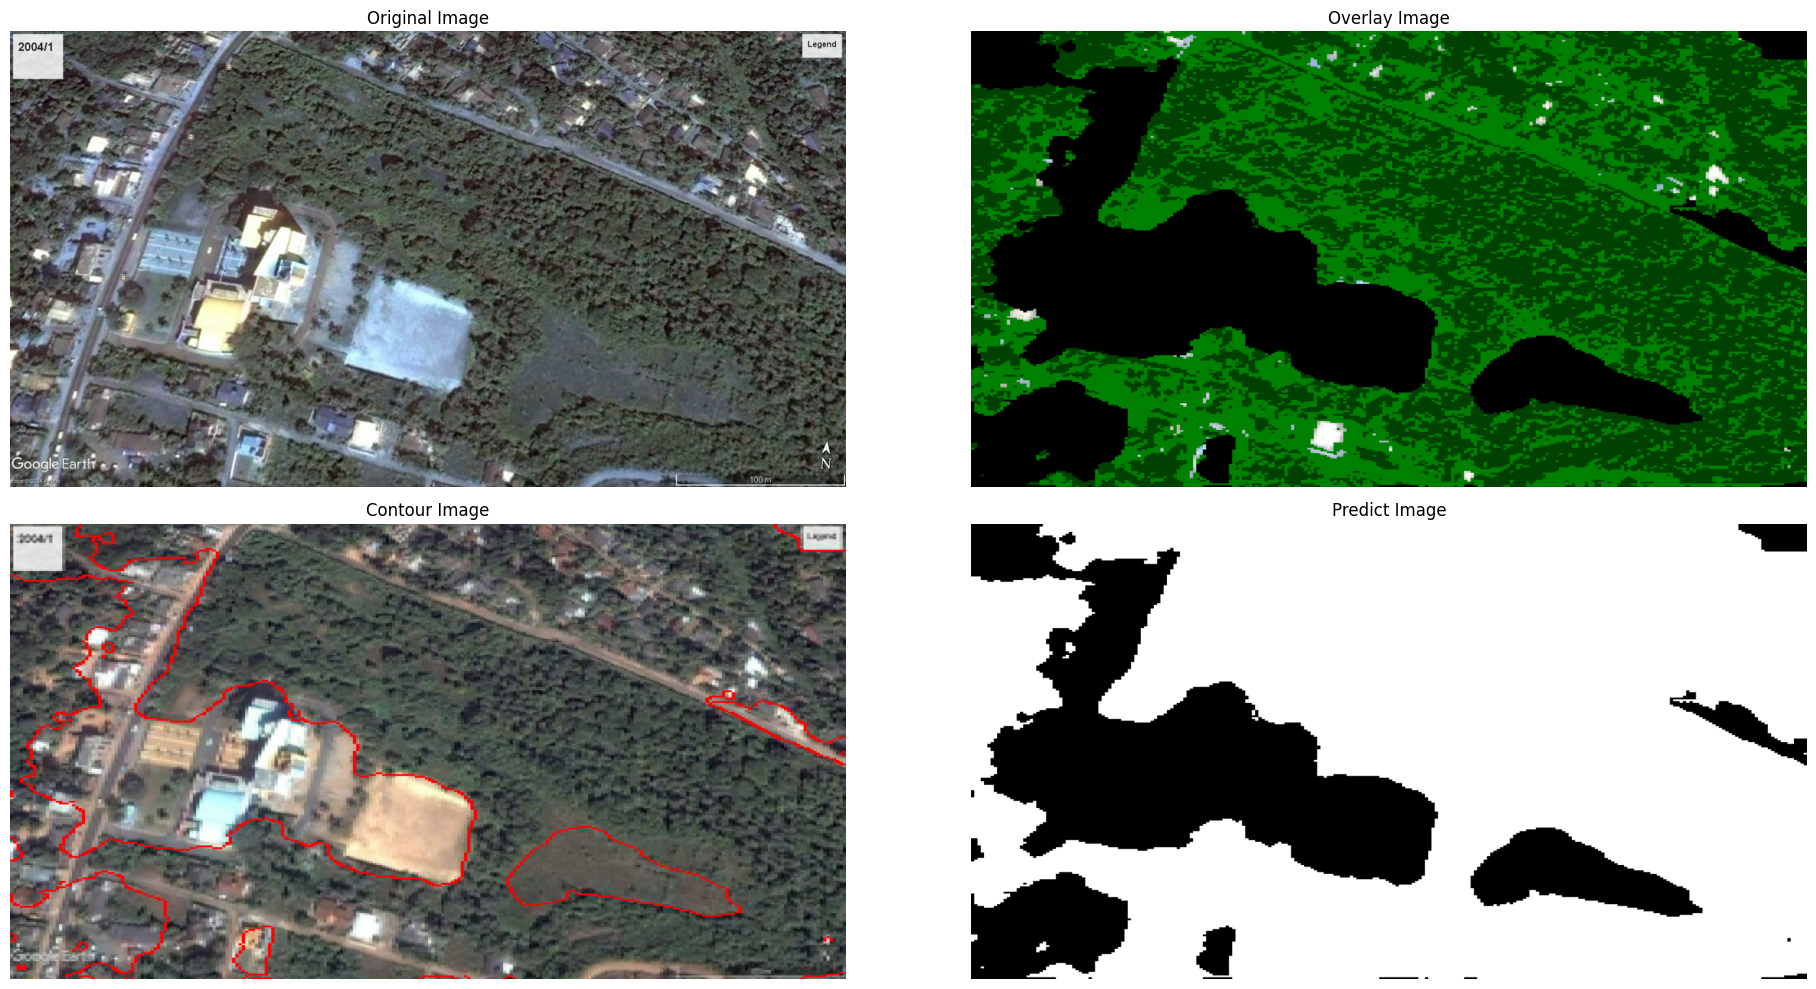

In [12]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.imshow(cv.imread(response['segmentation_results']['original']))
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv.imread(response['segmentation_results']['overlay']))
plt.title('Overlay Image')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv.imread(response['segmentation_results']['contour']))
plt.title('Contour Image')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv.imread(response['segmentation_results']['predict']))
plt.title('Predict Image')
plt.axis('off')

plt.tight_layout()
plt.show()